In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from numpy.testing import assert_allclose
from mcfit.transforms import *

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

import os 
path_to_class_sz = os.getcwd() + '/../../'

# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

Metal device set to: Apple M1 Pro


2023-03-24 12:24:20.690252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 12:24:20.690372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
zacharegas21_cosmo_redmagic = {
    
     # P18 1st column table 1 of https://arxiv.org/pdf/1807.06209.pdf
     # sigma8 and Omegam are from the Y3 analysis
     # see page 5 of https://arxiv.org/pdf/2106.08438.pdf
    'Omega_b': 0.0486,
    'Omega_cdm': 0.341-0.0486,
    'h':  0.6737,
    'tau_reio': 0.0543,
    'sigma8': 0.735,
    'n_s':  0.9649,
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06
    # 'omega_ur':0.0006
}

# for the fast computation:
zacharegas21_cosmo_redmagic_cosmopower = {
    
     # P18 1st column table 1 of https://arxiv.org/pdf/1807.06209.pdf
     # sigma8 and Omegam are from the Y3 analysis
     # see page 5 of https://arxiv.org/pdf/2106.08438.pdf
    'omega_b': 0.0486*0.6737**2,
    'omega_cdm': (0.341-0.0486)*0.6737**2,
    'H0':  100.*0.6737,
    'tau_reio': 0.0543,
    'ln10^{10}A_s': 2.7177747638974306,
    'n_s':  0.9649,
    # 'k_pivot': 0.05,
    # 'N_ncdm': 1,
    # 'N_ur': 2.0328,
    # 'm_ncdm': 0.06
    # 'omega_ur':0.0006
}


#Here is the bestfit (theta, gammat) from Georgios, for bin 1/3 with bestfit parameters:
#these are 200c masses (-> typo in the table legend of table D1 https://arxiv.org/pdf/2106.08438.pdf)
#log10(Mmin)=11.97, log10(M1)=13.51, sigma_logM=0.26, alpha=1.88, fcen=0.12, log10(Mstar)=11.18, csat/cdm=1.09, m=-3.63e-2, Delta z_l=0.00, Delta z_s=1.07e-3 

In [3]:
%%time
M = Class()
M.set(zacharegas21_cosmo_redmagic)
M.set({

'output':'gamma_gal_gallens_1h,gamma_gal_gallens_2h',
# 'output':'gal_gallens_1h,gal_gallens_2h',
'ell_max' : 5e5,
'ell_min' : 2,
'dlogell':0.3,
'mass function':'T08M200c',
'M_min':1e8,
'M_max':1e+17,
'z_min':1e-5,
'z_max': 4.,
'delta for galaxies':'200c',
'delta for matter density':'200c',
'concentration parameter':'B13',
'M_min_HOD':10.**11.97*zacharegas21_cosmo_redmagic['h'],
'M1_prime_HOD':10.**13.51*zacharegas21_cosmo_redmagic['h'],
'sigma_log10M_HOD':0.26,
'alpha_s_HOD':1.88,
'x_out_truncated_nfw_profile_satellite_galaxies':1.09,
'f_cen_HOD': 0.12,
'Delta_z_lens':0.00,
'Delta_z_source':1.07e-3,
'galaxy_sample' : 'custom',
'full_path_to_dndz_gal' : path_to_class_sz+'class_sz_auxiliary_files/nz_redmagic_z_bin1.txt', # lens galaxies
'full_path_to_source_dndz_gal' : path_to_class_sz+'class_sz_auxiliary_files/nz_redmagic_source_z_bin3.txt', # source galaxies
'N_samp_fftw':8000, #precision parameter for the bessel transform to theta space
'l_min_samp_fftw' : 1e-12,
'l_max_samp_fftw' : 1e12,
'hm_consistency': 0,
#'ndim_redshifts': 150,
#'ndim_masses': 150,
# 'P_k_max_h/Mpc':6e2,
# 'k_max_for_pk_class_sz':4e2,
'non_linear':'halofit',
'use_pknl_in_2hterms':1, # see paragraph Halo Model in https://arxiv.org/pdf/2106.08438.pdf
})
M.compute()

CPU times: user 35.3 s, sys: 154 ms, total: 35.5 s
Wall time: 4.83 s


In [4]:
As = M.get_current_derived_parameters(['A_s'])['A_s']
np.log(1e10*As)

2.7177747638974306

In [5]:
M.get_current_derived_parameters(['m_ncdm_tot'])['m_ncdm_tot']/93.14

0.000644201390367384

In [13]:
%%time
Mfast = Class()
Mfast.set(zacharegas21_cosmo_redmagic_cosmopower)
Mfast.set({

'output':'gal_gallens_1h,gal_gallens_2h',
# 'output':'gal_gallens_1h,gal_gallens_2h',
'ell_max' : 5e5,
'ell_min' : 2,
'dlogell':0.3,
'mass function':'T08M200c',
'M_min':1e8,
'M_max':1e+17,
'z_min':1e-5,
'z_max': 4.,
'delta for galaxies':'200c',
'delta for matter density':'200c',
'concentration parameter':'B13',
'M_min_HOD':10.**11.97*zacharegas21_cosmo_redmagic['h'],
'M1_prime_HOD':10.**13.51*zacharegas21_cosmo_redmagic['h'],
'sigma_log10M_HOD':0.26,
'alpha_s_HOD':1.88,
'x_out_truncated_nfw_profile_satellite_galaxies':1.09,
'f_cen_HOD': 0.12,
'Delta_z_lens':0.00,
'Delta_z_source':1.07e-3,
'galaxy_sample' : 'custom',
'full_path_to_dndz_gal' : path_to_class_sz+'class_sz_auxiliary_files/nz_redmagic_z_bin1.txt', # lens galaxies
'full_path_to_source_dndz_gal' : path_to_class_sz+'class_sz_auxiliary_files/nz_redmagic_source_z_bin3.txt', # source galaxies
# 'N_samp_fftw':8000, #precision parameter for the bessel transform to theta space
# 'l_min_samp_fftw' : 1e-8,
# 'l_max_samp_fftw' : 1e8,
'hm_consistency': 0,
'ndim_redshifts': 80,
})
Mfast.compute_class_szfast()
Mfast.get_sigma8_at_z(0.)
# M = Mfast

CPU times: user 13.7 s, sys: 169 ms, total: 13.9 s
Wall time: 1.91 s


array(0.73500216)

In [6]:
z,nz = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/nz_redmagic_source_z_bin3.txt',unpack=True)
print(np.trapz(nz,x=z))
z,nz = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/nz_redmagic_z_bin1.txt',unpack=True)
print(np.trapz(nz,x=z))

1.0000000000000002
1.0


In [7]:
gamma_t_thetas = np.asarray(M.gamma_ggamma()['thetas'])
gamma_t_1h = np.asarray(M.gamma_ggamma()['1h'])
gamma_t_2h = np.asarray(M.gamma_ggamma()['2h'])

cl_g_gamma_ell = np.asarray(M.cl_ggamma()['ell'])
cl_g_gamma_1h = np.asarray(M.cl_ggamma()['1h'])
cl_g_gamma_2h = np.asarray(M.cl_ggamma()['2h'])
m_gammat = -3.63e-2

In [8]:
%%time
x = np.logspace(-6, 6, num=600, endpoint=False)
cltt = cl_g_gamma_1h/l_to_dl(cl_g_gamma_ell)
clttfunc = interp1d(cl_g_gamma_ell,cltt,kind='cubic', axis=-1, copy=True, bounds_error=False, fill_value=1e-100, assume_sorted=False)
F = clttfunc(x)
H = Hankel(x, nu=2, q=1, N=1024, lowring=True)
y, G = H(F, extrap=True)
cltt = cl_g_gamma_2h/l_to_dl(cl_g_gamma_ell)
clttfunc = interp1d(cl_g_gamma_ell,cltt,kind='cubic', axis=-1, copy=True, bounds_error=False, fill_value=1e-100, assume_sorted=False)
F = clttfunc(x)
H = Hankel(x, nu=2, q=1, N=1024, lowring=True)
y, G2h = H(F, extrap=True)
print((y*x[::-1])[0])
theta = y*(60.*180.)/np.pi
# ax.plot(theta,G/2./np.pi,label='mcfit method')



0.9987082407509938
CPU times: user 4.78 ms, sys: 4.04 ms, total: 8.82 ms
Wall time: 11.6 ms


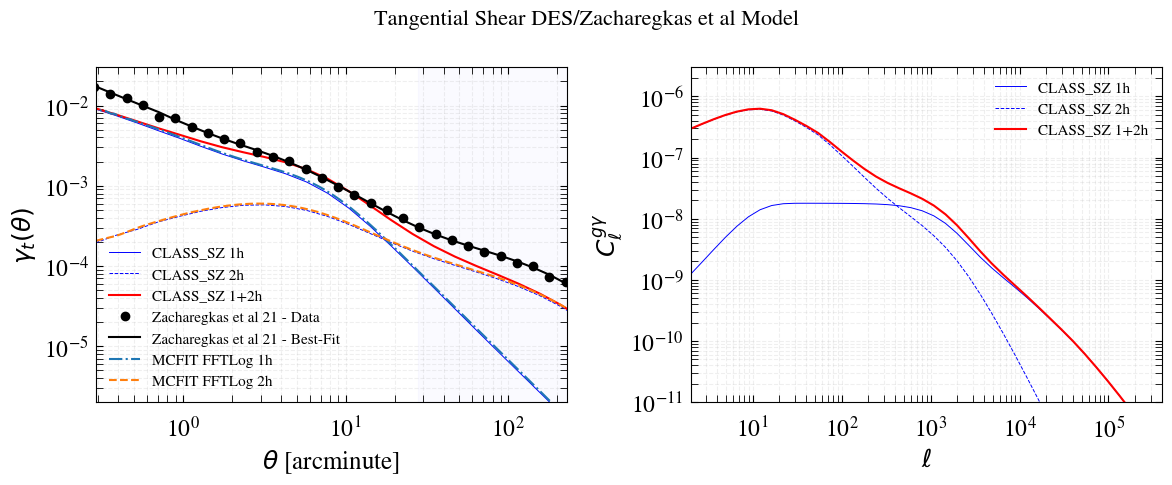

In [9]:

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r'$\theta$ [arcminute]',size=title_size)
ax.set_ylabel(r'$\gamma_t(\theta)$',size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(2e-6,3e-2)
ax.set_xlim(2.9e-1,2.3e2)
ax.plot(gamma_t_thetas,(1.+m_gammat)*gamma_t_1h,label='CLASS_SZ 1h',c='b',ls='-',lw=0.7)
ax.plot(gamma_t_thetas,(1.+m_gammat)*gamma_t_2h,label='CLASS_SZ 2h',c='b',ls='--',lw=0.7)
ax.plot(gamma_t_thetas,(1.+m_gammat)*(gamma_t_2h+gamma_t_1h),label='CLASS_SZ 1+2h',c='r')
th_z21, gammat_z21 = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/gammat_1_3.txt',unpack=True)
ax.plot(th_z21,gammat_z21,label='Zacharegkas et al 21 - Data',marker='o',c='k',ls='None')
th_z21, gammat_z21 = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/gammat_1_3_bf.txt',unpack=True)
ax.plot(th_z21,gammat_z21,label='Zacharegkas et al 21 - Best-Fit',ls='-',c='k')


ax.plot(theta,G/2./np.pi,label='MCFIT FFTLog 1h',ls='-.')
ax.plot(theta,G2h/2./np.pi,label='MCFIT FFTLog 2h',ls='--')

ax.axvspan(28,2.3e2,alpha=0.02,color='b')

ax.legend(loc=3,ncol = 1,frameon=False,fontsize=11)


ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r'$\ell$',size=title_size)
ax.set_ylabel(r'$C_\ell^{g\gamma}$',size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-11,3e-6)
ax.set_xlim(2.,4e5)
fac = cl_g_gamma_ell*(cl_g_gamma_ell+1.)/2./np.pi
ax.plot(cl_g_gamma_ell,cl_g_gamma_1h/fac,label='CLASS_SZ 1h',c='b',ls='-',lw=0.7)
ax.plot(cl_g_gamma_ell,cl_g_gamma_2h/fac,label='CLASS_SZ 2h',c='b',ls='--',lw=0.7)
ax.plot(cl_g_gamma_ell,cl_g_gamma_1h/fac+cl_g_gamma_2h/fac,label='CLASS_SZ 1+2h',c='r')


ax.legend(loc=1,ncol = 1,frameon=False,fontsize=11)

fig.tight_layout()
fig.suptitle('Tangential Shear DES/Zacharegkas et al Model',fontsize=16)
fig.tight_layout()
plt.savefig('../../notebooks/class_sz_tutorial_notebooks/figures/class_sz_tangential_shear_DES.pdf')

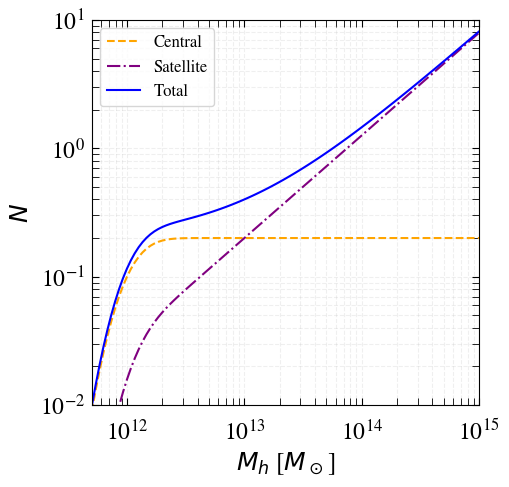

In [10]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r'$N$',size=title_size)
ax.set_xlabel(r'$M_h$ [$M_\odot$]',size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e1)
ax.set_xlim(5e11,1e15)
M_arr = np.geomspace(5e11,1e15,100)
get_N_centrals = np.vectorize(M.get_N_centrals)
Nc = get_N_centrals(0.,M_arr,1e12,0.25,0.2)
get_N_sats = np.vectorize(M.get_N_satellites)
Ns = get_N_sats(0.,M_arr,Nc,0.,0.8,1e13)
ax.plot(M_arr,Nc,ls='--',c='orange',label='Central')
ax.plot(M_arr,Ns,ls='-.',c='purple',label='Satellite')
ax.plot(M_arr,Ns+Nc,ls='-',c='b',label='Total')
ax.legend(loc=2,ncol = 1,frameon=True,fontsize=12)
#plt.savefig('HOD_fig1_2106.08438.pdf')